In [1]:
import matplotlib.pyplot as plt  # 視覺化呈現
import numpy as np  # 矩陣資料操作
import pandas as pd  # 表格資料處理
import cv2  # 數位影像操作

from tqdm import tqdm  # 進度條
import os  # 操作系統接口
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 設定使用的 GPU

In [2]:
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import keras

Using TensorFlow backend.


In [3]:
# 資料集放置路徑
data_path = r"C:\Users\Administrator\jianjun.qiao\LGP_images\train"  

# 讀入所有檔案路徑
x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    print(roots)
    if roots.find('check') == -1:
        for each in files:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("\\")[-1])

C:\Users\Administrator\jianjun.qiao\LGP_images\train
C:\Users\Administrator\jianjun.qiao\LGP_images\train\LLPM
C:\Users\Administrator\jianjun.qiao\LGP_images\train\OK
C:\Users\Administrator\jianjun.qiao\LGP_images\train\YSBD
C:\Users\Administrator\jianjun.qiao\LGP_images\train\YSCQ


In [4]:
x_data_list[:5]

['C:\\Users\\Administrator\\jianjun.qiao\\LGP_images\\train\\LLPM\\LGP-PrintFV-HB-P#6^19_20191226-152337_039392_AIresult.jpg',
 'C:\\Users\\Administrator\\jianjun.qiao\\LGP_images\\train\\LLPM\\LGP-PrintFV-HB-P#6^19_20191227-111639_011006_AIresult.jpg',
 'C:\\Users\\Administrator\\jianjun.qiao\\LGP_images\\train\\LLPM\\LGP-PrintFV-HB-P#6^19_20191227-111639_089128_AIresult.jpg',
 'C:\\Users\\Administrator\\jianjun.qiao\\LGP_images\\train\\LLPM\\LGP-PrintFV-HB-P#6^19_20191227-112025_261316_AIresult.jpg',
 'C:\\Users\\Administrator\\jianjun.qiao\\LGP_images\\train\\LLPM\\LGP-PrintFV-HB-P#6^19_20191227-113027_658047_AIresult.jpg']

In [5]:
y_data_list[:5]

['LLPM', 'LLPM', 'LLPM', 'LLPM', 'LLPM']

In [6]:
img_size = 224

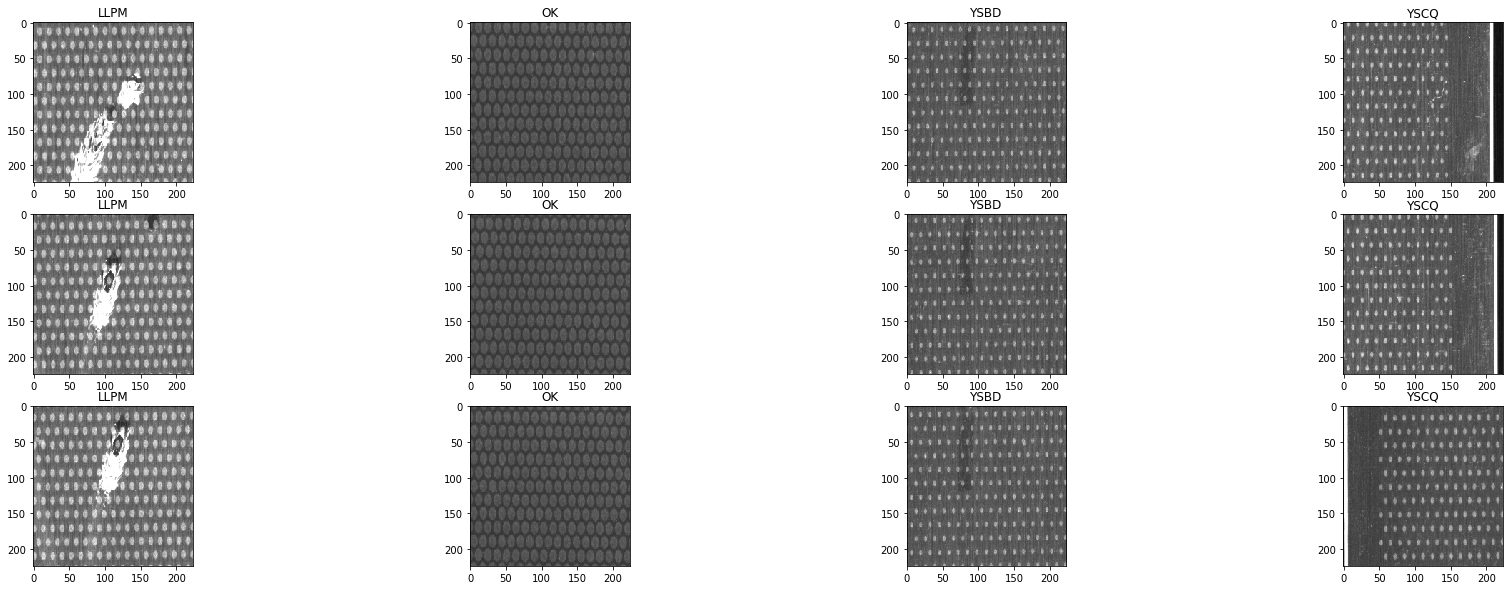

In [7]:
x_data = np.array(x_data_list)
y_data = np.array(y_data_list)

class_num = len(np.unique(y_data))

plt.figure(figsize=(30, 10))

# 觀看各個類別的影像
for j in range(3):
    for i, i_label in list(enumerate(np.unique(y_data_list))):
        x_label = x_data[y_data==i_label]
        img = cv2.imread(x_label[j])
        img = cv2.resize(img[:,:,::-1], (img_size, img_size))
        plt.subplot(3, class_num, j*class_num+i+1)
        plt.imshow(img)
        plt.title(i_label)

In [8]:
#data distribution
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [9]:
data_list.head(5)

,img_path,label
0,C:\Users\Administrator\jianjun.qiao\LGP_images...,LLPM
1,C:\Users\Administrator\jianjun.qiao\LGP_images...,LLPM
2,C:\Users\Administrator\jianjun.qiao\LGP_images...,LLPM
3,C:\Users\Administrator\jianjun.qiao\LGP_images...,LLPM
4,C:\Users\Administrator\jianjun.qiao\LGP_images...,LLPM


In [10]:
uniques = data_list['label'].value_counts().index  # 共有幾個類別
counts = data_list['label'].value_counts().values  # 每個類別的數量

# Observe the distribution of training data

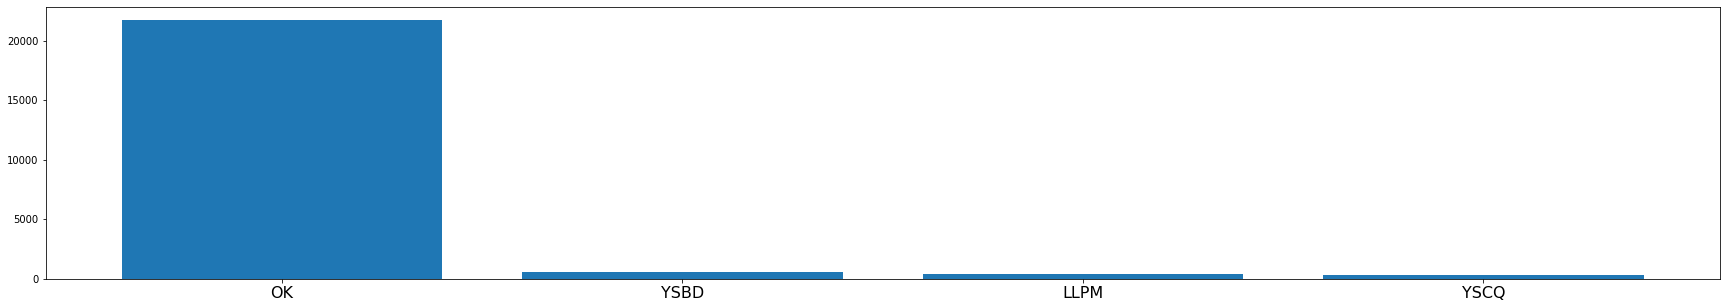

In [11]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

### 将数据分为训练集与测试集，并且每次都是随机按8：2分割

In [12]:
from sklearn.model_selection import train_test_split
import time

train_list, valid_list = train_test_split(data_list,
                                          test_size=0.2,  #样本占比
                                          random_state=int(time.time()),#随机数种子，每次都填一样的数 可以保证随机切分的数组一样
                                          stratify=data_list['label'])

train_list = train_list.reset_index(drop=True)
valid_list = valid_list.reset_index(drop=True)

In [13]:
num_classes = len(uniques)
print(num_classes) #类别数

4


In [14]:
train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='reflect',
                                   rescale=1./255
                                   )
valid_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    directory='',
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=(img_size, img_size),
                                                    batch_size=32,
                                                    color_mode='grayscale',
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_list,
                                                    directory='',
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=(img_size, img_size),
                                                    batch_size=32,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 18416 validated image filenames belonging to 4 classes.
Found 4604 validated image filenames belonging to 4 classes.


# Deal with Imbalanced Data

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [17]:
class_weights

array([15.24503311,  0.26464333,  9.75423729, 18.79183673])

In [18]:
# 重複取樣
new_train_list = train_list.copy()
for i in list(train_generator.class_indices.keys()):
    repeat_times = int(np.round((class_weights[train_generator.class_indices[i]])/class_weights.min()))
    print(i, ':', repeat_times)
    for j in range(repeat_times-1):
        new_train_list = pd.concat((new_train_list, train_list[train_list['label']==i]))

LLPM : 58
OK : 1
YSBD : 37
YSCQ : 71


# Observe the distribution of training data

In [19]:
uniques = new_train_list['label'].value_counts().index
counts = new_train_list['label'].value_counts().values

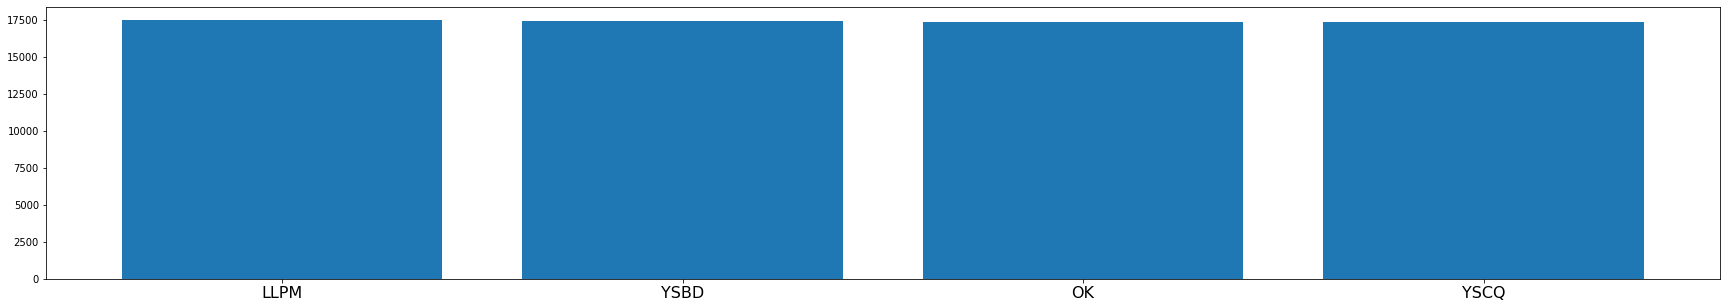

In [20]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

# Observe the distribution of valid data

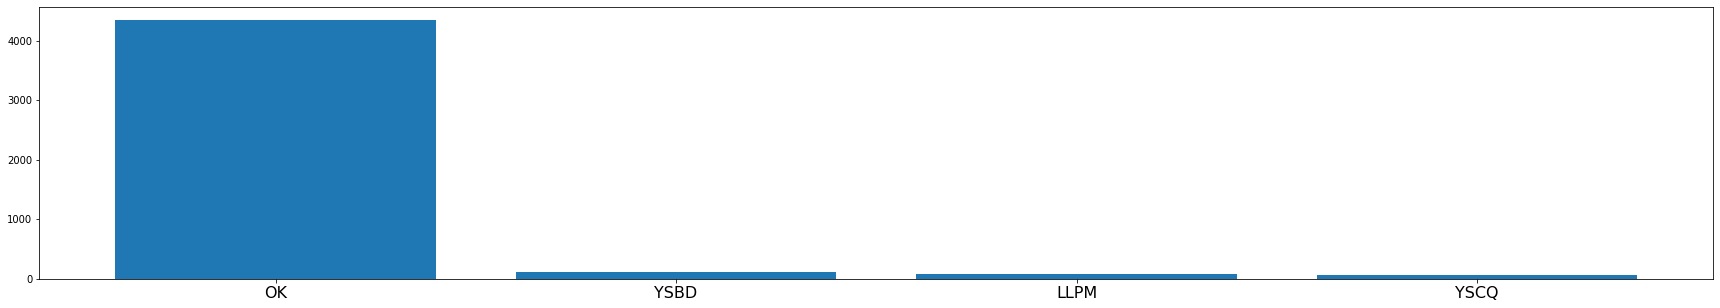

In [21]:
val_uniques = valid_list['label'].value_counts().index
val_counts = valid_list['label'].value_counts().values

plt.figure(figsize=(30, 5))
plt.bar(val_uniques, val_counts)
plt.xticks(fontsize=16)
plt.show()

In [22]:
from keras_efficientnets import EfficientNetB0, BlockArgs,preprocess_input

In [23]:
train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='wrap',
                                   rescale=1./255,
                                   preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=preprocess_input)

In [25]:
train_generator = train_datagen.flow_from_dataframe(dataframe=new_train_list,
                                                    directory='',
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_list,
                                                    directory='',
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 69772 validated image filenames belonging to 4 classes.
Found 4604 validated image filenames belonging to 4 classes.


In [26]:
def effnet():
    base_model = EfficientNetB0(weights='imagenet',include_top=False)
    base_model.trainable = False
    pool = keras.layers.GlobalAveragePooling2D()(base_model.output) 

    output = keras.layers.Dense(4, activation='softmax')(pool)
    model = keras.Model(inputs = base_model.input, outputs = output)
    return model

In [27]:
keras.backend.clear_session()
model = effnet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [28]:
# 編譯模型
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['acc'])

In [29]:
model_dir = './Model/model-logs-20200116'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('effnet_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_acc',
                                             verbose=1, 
                                             save_best_only=True)

callbacks_list = [model_mckp]

In [30]:
batch_size = 32
epochs = 50

# 訓練模型
history = model.fit_generator(train_generator,
                              steps_per_epoch=new_train_list.shape[0]//batch_size,
                              epochs=epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/50
2180/2180 [==============================] - 785s 360ms/step - loss: 0.1569 - acc: 0.9403 - val_loss: 0.0852 - val_acc: 0.9670

Epoch 00001: val_acc improved from -inf to 0.96699, saving model to ./Model/model-logs-20200116/effnet_model-best-model.h5
Epoch 2/50
2180/2180 [==============================] - 766s 351ms/step - loss: 0.0466 - acc: 0.9836 - val_loss: 0.0727 - val_acc: 0.9709

Epoch 00002: val_acc improved from 0.96699 to 0.97089, saving model to ./Model/model-logs-20200116/effnet_model-best-model.h5
Epoch 3/50
2180/2180 [==============================] - 781s 358ms/step - loss: 0.0310 - acc: 0.9895 - val_loss: 0.0327 - val_acc: 0.9878

Epoch 00003: val_acc improved from 0.97089 to 0.98784, saving model to ./Model/model-logs-20200116/effnet_model-best-model.h5
Epoch 4/50
2180/2180 [==============================] - 974s 447ms/step - loss: 0.0227 - acc: 0.9927 - val_loss: 0.0367 - val_acc: 0.9900

Epoch 00004: val_acc improved from 0.98784 to 0.99001, saving model t

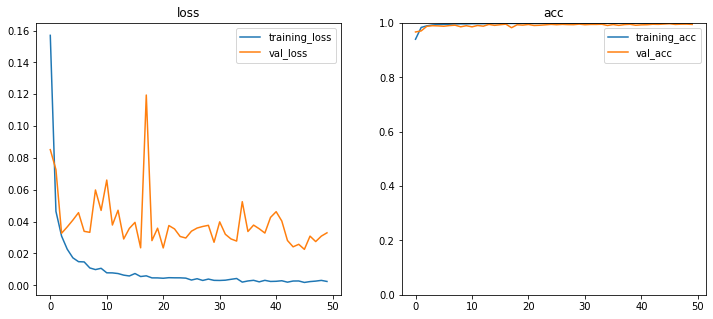

In [31]:
# 將訓練過程做視覺化的呈現
train_history = ['loss', 'val_loss', 'acc', 'val_acc']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title(eachy.split('_')[1])
    if i>2:
        plt.ylim((0, 1))
plt.show()

# Model evaluation

In [34]:
model = keras.models.load_model('./Model/model-logs-20200116/effnet_model-best-model.h5')

In [35]:
valid_pred = model.predict_generator(valid_generator)
valid_pred = valid_pred.argmax(-1)
valid_list.loc[:, 'generator_label'] = valid_list['label'].map(valid_generator.class_indices).values

# Accuracy

In [36]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(valid_list['generator_label'], valid_pred))

Accuracy: 0.9971763683753258


# Confusion matrix

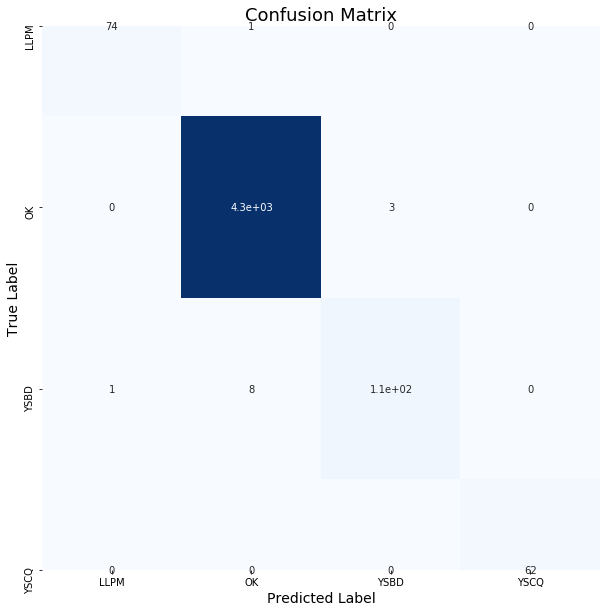

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix = confusion_matrix(valid_list['generator_label'], valid_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues", robust=True,
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Recal

In [38]:
from sklearn.metrics import recall_score
dict(zip(valid_generator.class_indices.keys(), recall_score(valid_list['generator_label'], valid_pred, average=None)))

{'LLPM': 0.9866666666666667,
 'OK': 0.9993101862497126,
 'YSBD': 0.923728813559322,
 'YSCQ': 1.0}

# 20% TEST DATA RESULT

![jupyter](./picture/a.png)

In [62]:
from keras.preprocessing.image import ImageDataGenerator
from keras_efficientnets import preprocess_input
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 設定使用的 GPU

img_size = 224
model = load_model('./Model/model-logs-20200116/effnet_model-best-model.h5')

In [63]:
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory('./images/test_images', target_size=(img_size, img_size),
                                                  batch_size=1,class_mode='categorical', shuffle=False,
                                                 )

Found 15 images belonging to 1 classes.


In [64]:
#如果我们同时使用了两个生成器，我们就需要对生成器进行reset
test_generator.reset()
pred = model.predict_generator(test_generator, verbose=1)

15/15 [==============================] - 4s 248ms/step


In [65]:
predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
label = dict((v,k) for k,v in labels.items())

In [ ]:
labels

In [67]:
# 建立代码标签与真实标签的关系
predictions = [label[i] for i in predicted_class_indices]
len(predictions)

15

In [68]:
filenames = test_generator.filenames
print(len(filenames))
LLPM,OK,YSBD,YSCQ = 0,0,0,0
for idx,filename in enumerate(filenames):
    print(idx,filename,predictions[idx])
    true_label = filename.split('\\')[0]  
    if predictions[idx]=='LLPM':
        LLPM+=1
    elif predictions[idx] == 'OK':
        OK+=1
    elif predictions[idx] == 'YSBD':
        YSBD+=1
    else:
        YSCQ+=1



15
0 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175329_048499_AIresult.jpg YSBD
1 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175329_110991_AIresult.jpg YSBD
2 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175342_016365_AIresult.jpg YSBD
3 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175359_171456_AIresult.jpg YSBD
4 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175441_543588_AIresult.jpg OK
5 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175555_429209_AIresult.jpg YSBD
6 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175611_709357_AIresult.jpg YSBD
7 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175624_474119_AIresult.jpg YSBD
8 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175640_332419_AIresult.jpg YSBD
9 YSBD\LGP-PrintFV-HB-P#6^19_20200102-175654_097115_AIresult.jpg YSBD
10 YSBD\LGP-PrintFV-HB-P#6^19_20200108-134049_733037_AIresult.jpg OK
11 YSBD\LGP-PrintFV-HB-P#6^19_20200108-134318_066329_AIresult.jpg YSBD
12 YSBD\LGP-PrintFV-HB-P#6^19_20200108-135438_049968_AIresult.jpg OK
13 YSBD\LGP-PrintFV-HB-P#6^19_20200108-135440_612225_AIresult.jpg OK
14 YSBD\LGP-PrintFV-H

In [69]:
print('LLPM:{}'.format(LLPM))
print('OK:{}'.format(OK))
print('YSBD:{}'.format(YSBD))
print('YSCQ:{}'.format(YSCQ))

LLPM:0
OK:5
YSBD:10
YSCQ:0
